In [9]:
!pip install torch-vision

You should consider upgrading via the '/Users/saugatbalami/Documents/Projects/Subarna/env/bin/python3 -m pip install --upgrade pip' command.


In [97]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.model_selection import train_test_split

In [98]:

# Load the CSV dataset
dataset = pd.read_csv('roomfinder.csv')
dataset.columns = ['Question', 'Response']
dataset.dropna(inplace=True)


In [99]:
dataset.head()

,Question,Response
0,What is room finder?,"Finding a rooms or flats for students, worker,..."
1,Booking a room safely,Although we have a team of moderators that wor...
2,Can you find me a room or flat?,Room finder is a room or flat share website an...
3,What is the purpose of the platform?,The platform aims to make finding a room or fl...
4,How do I sign up for the platform?,"Visit the homepage and click on the ""Sign Up"" ..."


In [100]:
print("\nData types of columns:")
print(dataset.dtypes)
print("\nShape of the dataset:")
print(dataset.shape)
print("\nMissing values:")
print(dataset.isnull().sum())


Data types of columns:
Question    object
Response    object
dtype: object

Shape of the dataset:
(101, 2)

Missing values:
Question    0
Response    0
dtype: int64


In [101]:
df = pd.read_csv('roomfinder.csv')
df.columns = ['question', 'answer']

# Length distribution of questions and answers
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)

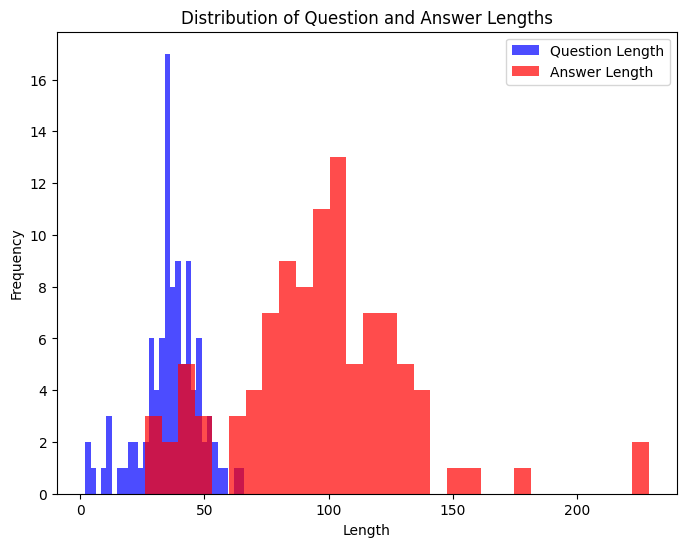

In [104]:
# Visualization
plt.figure(figsize=(8, 6))
plt.hist(df['question_length'], bins=30, alpha=0.7, color='blue', label='Question Length')
plt.hist(df['answer_length'], bins=30, alpha=0.7, color='red', label='Answer Length')
plt.title('Distribution of Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()

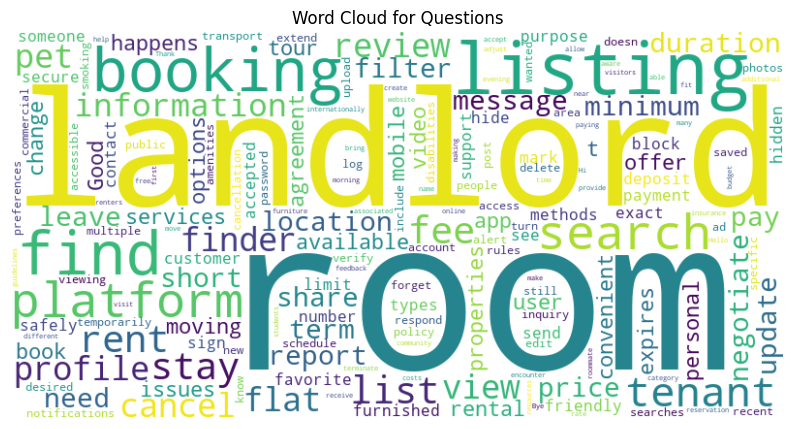

In [103]:
# Word cloud for questions
question_text = ' '.join(df['question'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(question_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')
plt.show()

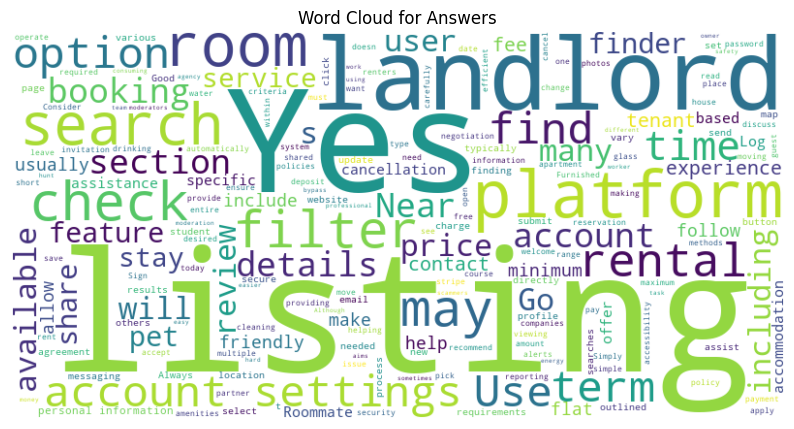

In [105]:
# Word cloud for answers
answer_text = ' '.join(df['answer'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(answer_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Answers')
plt.axis('off')
plt.show()

In [67]:

# Tokenization and Vocabulary Building
def tokenize(text):
    return text.lower().split()



In [68]:
# Build vocabulary and map words to indices
def build_vocab(sentences):
    tokenized_sentences = [tokenize(sentence) for sentence in sentences]
    vocab = Counter(token for sentence in tokenized_sentences for token in sentence)
    word2idx = {word: idx+1 for idx, (word, _) in enumerate(vocab.items())}
    word2idx['<PAD>'] = 0
    return word2idx



In [69]:
questions = dataset['Question'].values
responses = dataset['Response'].values

# Build vocab and encode questions
word2idx = build_vocab(questions)
vocab_size = len(word2idx)

# Load GloVe embeddings (download `glove.42B.300d.txt` and provide the correct path)
def load_glove_embeddings(glove_file_path, word2idx, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            embeddings_index[word] = embedding

    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word2idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [70]:
# Update dimensions for the glove.42B.300d embeddings
embedding_dim = 300
glove_file_path = 'glove.42B.300d.txt' 
embedding_matrix = load_glove_embeddings(glove_file_path, word2idx, embedding_dim)



In [71]:
# Encode sentences to sequences of indices
def encode_sentence(sentence, word2idx):
    return [word2idx.get(token, 0) for token in tokenize(sentence)]



In [72]:
encoded_questions = [torch.tensor(encode_sentence(sentence, word2idx)) for sentence in questions]



In [73]:
# Pad sequences to ensure uniform length
padded_questions = pad_sequence(encoded_questions, batch_first=True, padding_value=word2idx['<PAD>'])
max_seq_length = padded_questions.shape[1]


In [74]:

# Encode responses
label_encoder = LabelEncoder()
encoded_responses = label_encoder.fit_transform(responses)
encoded_responses = torch.tensor(encoded_responses)


In [75]:

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(padded_questions, encoded_responses, test_size=0.1)



In [76]:
# DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [77]:

# Define the Improved RNN model using PyTorch (Bidirectional LSTM with GloVe)
class ImprovedRNNChatBot(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix=None):
        super(ImprovedRNNChatBot, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Load pretrained embeddings if provided
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
            self.embedding.weight.requires_grad = False  # Freeze embeddings if needed
            
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Use *2 for bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        packed_output, (hidden, _) = self.lstm(embedded)
        # Concatenate final forward and backward hidden states
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc(hidden)
        return out


In [78]:

# Model parameters
hidden_dim = 128  # Increased hidden units
output_dim = len(label_encoder.classes_)



In [79]:
 #Instantiate the model
model = ImprovedRNNChatBot(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix=embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [80]:

# Training the model
epochs = 20  # Increase epochs for better training
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        X_batch, y_batch = batch
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


Epoch 1, Loss: 4.726210594177246
Epoch 2, Loss: 4.521711349487305
Epoch 3, Loss: 4.45147705078125
Epoch 4, Loss: 3.721613883972168
Epoch 5, Loss: 3.5722739696502686
Epoch 6, Loss: 2.607476234436035
Epoch 7, Loss: 2.1511011123657227
Epoch 8, Loss: 1.641419529914856
Epoch 9, Loss: 0.9409624934196472
Epoch 10, Loss: 0.4199603796005249
Epoch 11, Loss: 0.2652970850467682
Epoch 12, Loss: 0.3980405330657959
Epoch 13, Loss: 0.18017111718654633
Epoch 14, Loss: 0.0980619341135025
Epoch 15, Loss: 0.06864065676927567
Epoch 16, Loss: 0.059103310108184814
Epoch 17, Loss: 0.035091228783130646
Epoch 18, Loss: 0.03869732469320297
Epoch 19, Loss: 0.022234931588172913
Epoch 20, Loss: 0.024980906397104263


In [81]:

# Function to predict a response
def predict_response(model, input_text, word2idx, label_encoder, max_seq_length):
    model.eval()
    encoded_input = torch.tensor(encode_sentence(input_text, word2idx)).unsqueeze(0)
    
    # Pad the input to match the sequence length used in training
    if encoded_input.shape[1] < max_seq_length:
        padding = torch.zeros((1, max_seq_length - encoded_input.shape[1]), dtype=torch.long)
        encoded_input = torch.cat([encoded_input, padding], dim=1)
    elif encoded_input.shape[1] > max_seq_length:
        encoded_input = encoded_input[:, :max_seq_length]
    
    with torch.no_grad():
        output = model(encoded_input)
        predicted_label = torch.argmax(output, dim=1).item()
        return label_encoder.inverse_transform([predicted_label])[0]

In [135]:
# Example usage
input_question = "can i receive any visitos?"
response = predict_response(model, input_question, word2idx, label_encoder, max_seq_length)
print(f"Input: {input_question}")
print(f"Response: {response}")


Input: can i receive any visitos?
Response: Of course you can receive visitors; they do not have to sign in.


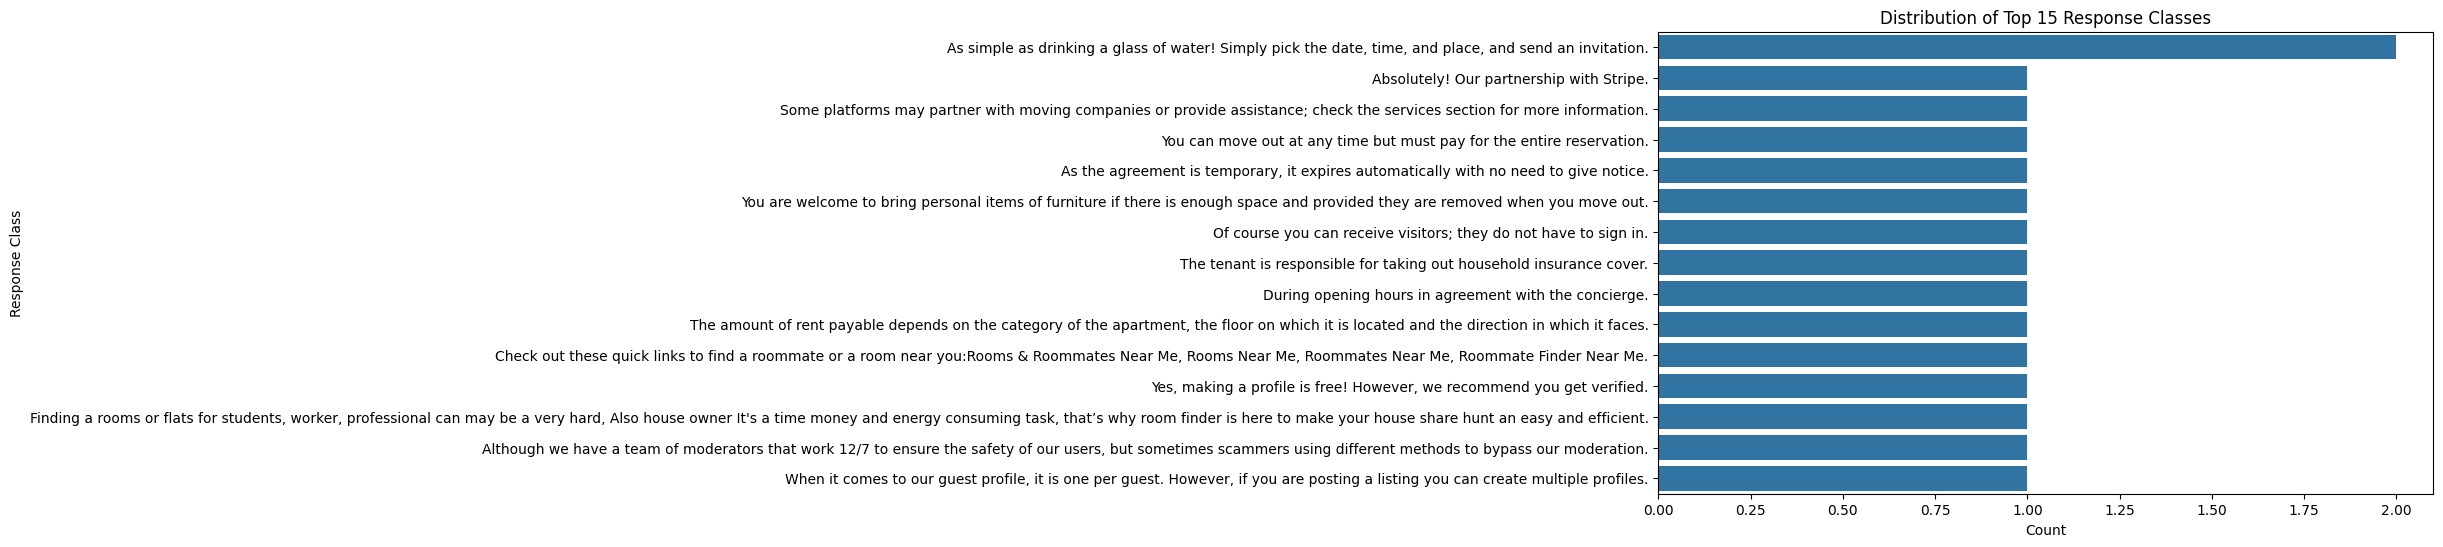

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display the distribution of the top 15 response classes
plt.figure(figsize=(10, 6))
top_responses = dataset['Response'].value_counts().nlargest(15).index  # Select top 15 responses
sns.countplot(y=dataset['Response'], order=top_responses)
plt.title('Distribution of Top 15 Response Classes')
plt.xlabel('Count')
plt.ylabel('Response Class')
plt.show()




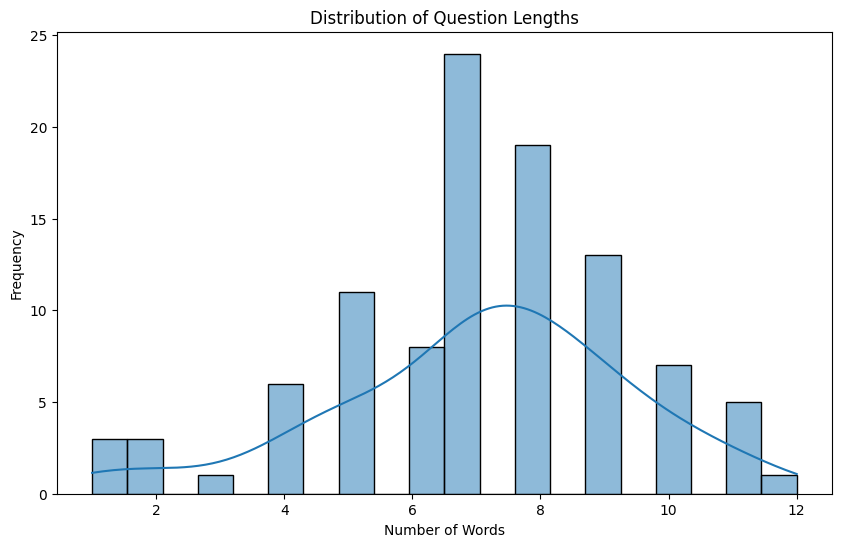

In [30]:
# 2. Length of Questions
dataset['Question Length'] = dataset['Question'].apply(lambda x: len(tokenize(x)))

plt.figure(figsize=(10, 6))
sns.histplot(dataset['Question Length'], bins=20, kde=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


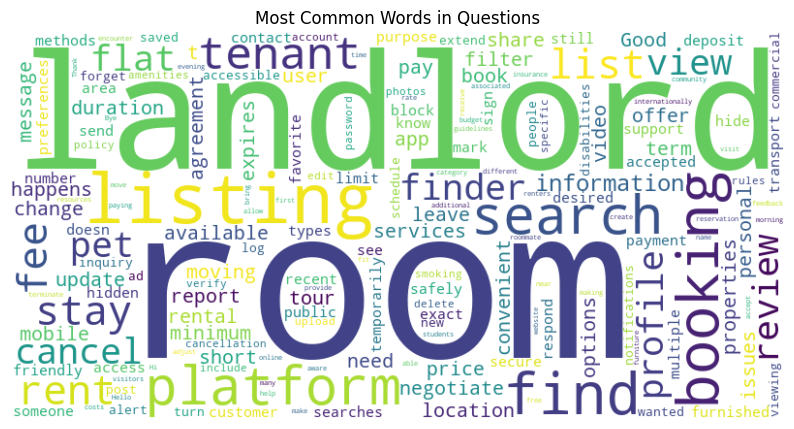

In [31]:
# 3. Top Words in Questions
from wordcloud import WordCloud

all_text = ' '.join(dataset['Question'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Questions')
plt.show()

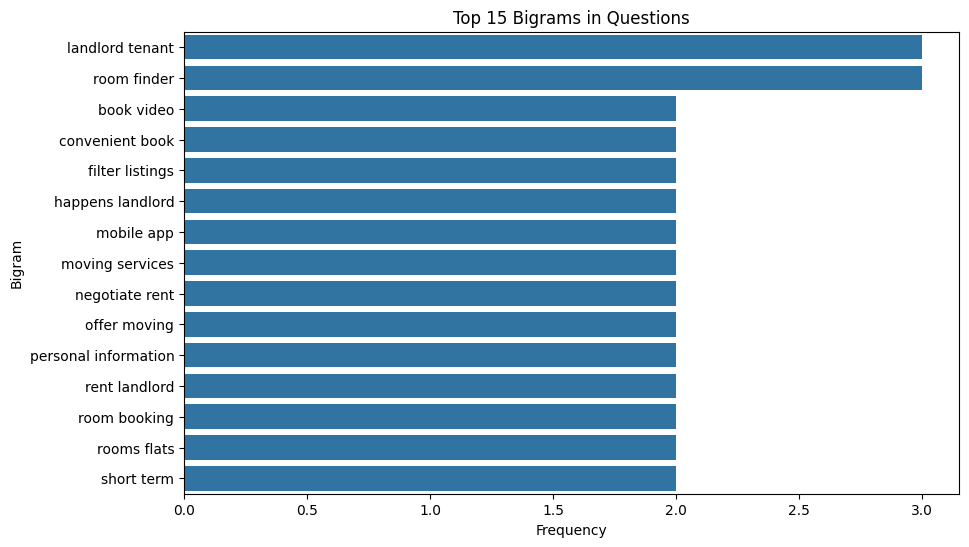

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract and visualize bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_bigrams = vectorizer.fit_transform(dataset['Question'])
bigram_freq = np.array(X_bigrams.sum(axis=0)).flatten()
bigram_names = vectorizer.get_feature_names_out()

# Get top 15 bigrams
bigram_data = pd.DataFrame({'bigram': bigram_names, 'frequency': bigram_freq})
top_bigrams = bigram_data.nlargest(15, 'frequency')

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='bigram', data=top_bigrams)
plt.title('Top 15 Bigrams in Questions')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()


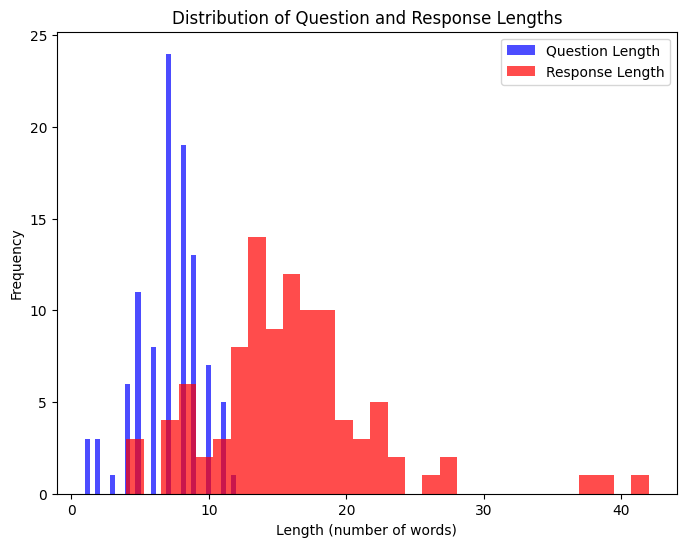

In [43]:
# Calculate the length of questions and responses
dataset['Question Length'] = dataset['Question'].apply(lambda x: len(x.split()))
dataset['Response Length'] = dataset['Response'].apply(lambda x: len(x.split()))

# Visualization
plt.figure(figsize=(8, 6))
plt.hist(dataset['Question Length'], bins=30, alpha=0.7, color='blue', label='Question Length')
plt.hist(dataset['Response Length'], bins=30, alpha=0.7, color='red', label='Response Length')
plt.title('Distribution of Question and Response Lengths')
plt.xlabel('Length (number of words)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [122]:
# Step 1: Convert indices in X_val back to readable text (questions)
idx2word = {v: k for k, v in word2idx.items()}
questions_text = []

for seq in X_val:
    words = [idx2word[idx.item()] for idx in seq if idx.item() != word2idx['<PAD>']]  # Convert indices to words, remove padding
    questions_text.append(' '.join(words))  # Join words to form the original question text

# Step 2: Convert the true and predicted labels to text responses
# Use label_encoder to map numerical labels to their text responses
y_true_text = label_encoder.inverse_transform(y_true)
y_pred_text = label_encoder.inverse_transform(y_pred)

# Step 3: Create a DataFrame to compare Real Questions, True Responses, and Predicted Responses
comparison_df = pd.DataFrame({
    'Real Question': questions_text,
    'True Response': y_true_text, 
    'Predicted Response': y_pred_text
})



In [123]:
a

,Real Question,True Response,Predicted Response
0,is there a fee associated with making a booking?,Most rental platforms have a mobile app availa...,Minimum stay requirements can vary. Please che...
1,what payment methods are accepted?,"Yes, you can typically upload photos while cre...",You are welcome to bring personal items of fur...
2,can i upload photos to my listing?,Some platforms may partner with moving compani...,Of course you can receive visitors; they do no...
3,how do i find listings that allow pets?,Check the platform’s services section; some ma...,Of course you can receive visitors; they do no...
4,can i view a room before booking it?,"Visit the homepage and click on the ""Sign Up"" ...",Go to your account settings and enable notific...
5,how convenient is it to book a video tour?,"No, only websites available.",Minimum stay requirements can vary. Please che...
6,why does the website list different prices for...,Most platforms will automatically log you out ...,During opening hours in agreement with the con...
7,what should i do if i encounter issues during ...,Many platforms allow users to post wanted ads;...,"Yes, after your stay, you will typically have ..."
8,are profiles free to make?,Hello! How can I assist you today?,Hi there! How may I help you?
9,how can i search for pet-friendly rooms?,It's important to read the listing details car...,Most listings specify rules about pets or smok...


In [136]:
import torch

# Save the model state dictionary
model_save_path = 'chatbot_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to chatbot_model.pth


/Users/saugatbalami/Documents/Projects/Subarna/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1, Training Loss: 4.6204
Epoch 2, Training Loss: 4.5186
Epoch 3, Training Loss: 4.4317
Epoch 4, Training Loss: 4.3314
Epoch 5, Training Loss: 4.1979
Epoch 6, Training Loss: 4.0576
Epoch 7, Training Loss: 3.8500
Epoch 8, Training Loss: 3.6387
Epoch 9, Training Loss: 3.4047
Epoch 10, Training Loss: 3.1311
Validation Loss: 5.0392, Validation Accuracy: 0.00%


/var/folders/yt/tbgnt18s5g72fq74jg2g2fvr0000gn/T/ipykernel_9207/304922314.py:28: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device('mps' if torch.has_mps else 'cpu')  # Use MPS if available, otherwise fallback to CPU
